In [40]:
nexid="krtx"
product=172
elev="0.0"
from awips.dataaccess import DataAccessLayer
from cartopy.feature import ShapelyFeature,NaturalEarthFeature
from awips import ThriftClient, RadarCommon
from dynamicserialize.dstypes.com.raytheon.uf.common.time import TimeRange
from dynamicserialize.dstypes.com.raytheon.uf.common.dataplugin.radar.request import GetRadarDataRecordRequest
from datetime import datetime
import matplotlib.pyplot as plt
from datetime import timedelta
from numpy import ma
from metpy.plots import ctables
#from awips.tables import nexrad
import numpy as np
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

nexrad = {
    "N0Q" : {
            'id': 94,
            'unit':'dBZ',
            'name':'0.5 deg Base Reflectivity',
            'ctable': ['NWSStormClearReflectivity',-20., 0.5],
            'res': 1000.,
            'elev': '0.5'},
    "N0U" : {
            'id': 99,
            'unit':'kts',
            'name':'0.5 deg Base Velocity',
            'ctable': ['NWS8bitVel',-100.,1.],
            'res': 250.,
            'elev': '0.5'},
    "EET" : {
            'id': 135,
            'unit':'kft',
            'name':'Enhanced Echo Tops',
            'ctable': ['NWSEnhancedEchoTops',0,1],
            'res': 1000.,
            'elev': '0.0'},
    "DST" : {
            'id': 172,
            'unit':'in',
            'name':'Storm Total Accumulation',
            'ctable': ['NWSStormClearReflectivity',0,1],
            'res': 250.,
            'elev': '0.0'}
}

def make_map(bbox, projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(14, 10),
            subplot_kw=dict(projection=projection))
    ax.set_extent(bbox)
    ax.coastlines(resolution='50m')
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 6}
    gl.ylabel_style = {'size': 6}
    return fig, ax

# set EDEX server and radar site definitions
request = DataAccessLayer.newDataRequest()
DataAccessLayer.changeEDEXHost('edex-cloud.unidata.ucar.edu')
request.setDatatype('radar')
request.setLocationNames(nexid)
request.setParameters(product)

# Get latest time
datatimes = DataAccessLayer.getAvailableTimes(request)
dateTimeStr = str(datatimes[-1])
dateTime = datetime.strptime(dateTimeStr, '%Y-%m-%d %H:%M:%S')
# Build timerange +/- 60 sec buffer
beginRange = dateTime - timedelta(0, 60)
endRange = dateTime + timedelta(0, 60)
timerange = TimeRange(beginRange, endRange)
# GetRadarDataRecordRequest to query site with timerange
client = ThriftClient.ThriftClient('edex-cloud.unidata.ucar.edu')
request = GetRadarDataRecordRequest()
request.setRadarId(nexid)
request.setTimeRange(timerange)

grids = []
nexrad_info = [kv for kv in nexrad.items() if kv[1]['id'] == product][0]
code = nexrad_info[0]

request.setProductCode(product)
request.setPrimaryElevationAngle(nexrad_info[1]['elev'])
response = client.sendRequest(request)

In [41]:
if response.getData():
    for record in response.getData():
        # Get hdf5
        idra = record.getHdf5Data()
        rdat,azdat,depVals,threshVals = RadarCommon.get_hdf5_data(idra)
        dim = rdat.getDimension()
        lat,lon = float(record.getLatitude()),float(record.getLongitude())
        radials,rangeGates = rdat.getSizes()
        
        # Convert raw byte to pixel value
        rawValue=np.array(rdat.getByteData())
        array = []
        for rec in rawValue:
            if rec<0:
                rec+=256
            array.append(rec)
        #array=rawValue
            
        if azdat:
            azVals = azdat.getFloatData()
            az = np.array(RadarCommon.encode_radial(azVals))
            dattyp = RadarCommon.get_data_type(azdat)
            az = np.append(az,az[-1])

        header = RadarCommon.get_header(record, format, rangeGates, radials, azdat, 'description')
        rng = np.linspace(0, rangeGates, rangeGates + 1)

        # Convert az/range to a lat/lon
        from pyproj import Geod
        g = Geod(ellps='clrk66')
        center_lat = np.ones([len(az),len(rng)])*lat
        center_lon = np.ones([len(az),len(rng)])*lon
        az2D = np.ones_like(center_lat)*az[:,None]
        rng2D = np.ones_like(center_lat)*np.transpose(rng[:,None])*nexrad[code]['res']
        lons,lats,back=g.fwd(center_lon,center_lat,az2D,rng2D)
        bbox = [lons.min(), lons.max(), lats.min(), lats.max()]

        # Create 2d array
        multiArray = np.reshape(array, (-1, rangeGates))
        data = ma.array(multiArray)
        if product==135:
            data[data<2] = ma.masked
        elif product==172:
            # <entry displayValue='0.0' pixelValue='6' />
            # <entry displayValue='0.1' pixelValue='16' />
            # <entry displayValue='0.3' pixelValue='32' />
            # <entry displayValue='0.6' pixelValue='48' />
            # <entry displayValue='1.0' pixelValue='64' />
            # <entry displayValue='1.5' pixelValue='80' />
            # <entry displayValue='2.0' pixelValue='96' />
            # <entry displayValue='2.5' pixelValue='112' />
            # <entry displayValue='3.0' pixelValue='128' />
            # <entry displayValue='4.0' pixelValue='144' />
            # <entry displayValue='5.0' pixelValue='160' />
            # <entry displayValue='6.0' pixelValue='176' />
            # <entry displayValue='8.0' pixelValue='192' />
            # <entry displayValue='10.0' pixelValue='208' />
            # <entry displayValue='12.0' pixelValue='224' />
            # <entry displayValue='15.0' pixelValue='240' />
            # <entry displayValue='31.0' pixelValue='255' />
            
            # The Scale and Offset used in the equation (F = (N - OFFSET) / SCALE), where 
            # N is the integer data value and F is the resulting floating point value) 
            # to relate the integer data values to physical units are ANSI/IEEE
            # Standard 754-1985 floating point values. Halfwords 31 and 32 contain the 
            # Scale, and halfwords 33 and 34 contain the Offset. 
            data = ma.array((multiArray - float(threshVals[1])/float(threshVals[0])))
            data[data==0] = ma.masked
        else:
            data = ma.array(threshVals[0]/10. + (data)*threshVals[1]/10.)
            if nexrad[code]['unit'] == 'kts':
                data[data<-63] = ma.masked
                data *= 1.94384 # Convert to knots
            else:
                data[data<=((threshVals[0]/10.)+threshVals[1]/10.)] = ma.masked
        
        # Save our requested grids so we can render them multiple times
        radar_grid = {
            "code": code,
            "bbox": bbox,
            "lats": lats,
            "lons": lons,
            "data": data
        }
        grids.append(radar_grid)

In [42]:
print("data values range from " +str(rawValue.min())+ " to " +str(rawValue.max()))
print("threshVals is " +str(threshVals))
print(timerange)
print(dateTime)
print(data.shape)

data values range from 0 to 27
threshVals is [16256     0     0     0     0   255     1     0     0     0     0     0
     0     0     0     0]
(Apr 05 17 01:18:06 , Apr 05 17 01:20:06 )
2017-04-05 01:19:06
(360, 920)


In [43]:
# set EDEX server and radar site definitions
request = DataAccessLayer.newDataRequest()
DataAccessLayer.changeEDEXHost('edex-cloud.unidata.ucar.edu')
request.setDatatype('radar')
request.setLocationNames(nexid) # nexid="krtx"
availableParms = DataAccessLayer.getAvailableParameters(request)
availableParms.sort()
list(availableParms)

[b'134',
 b'135',
 b'138',
 b'169',
 b'170',
 b'172',
 b'176',
 b'177',
 b'32',
 b'56',
 b'94',
 b'99',
 b'DAA',
 b'DHR',
 b'DPR',
 b'DVL',
 b'Digital Hybrid Scan Refl',
 b'Digital Inst Precip Rate',
 b'Digital Vert Integ Liq',
 b'EET',
 b'Enhanced Echo Tops',
 b'HHC',
 b'Hybrid Hydrometeor Class',
 b'OHA',
 b'One Hour Accum',
 b'One Hour Unbiased Accum',
 b'Reflectivity',
 b'SRM',
 b'STA',
 b'STP',
 b'Storm Rel Velocity',
 b'Storm Total Accum',
 b'Storm Total Precip',
 b'V',
 b'Velocity',
 b'Z']

In [44]:
request.setParameters(product) # product=172
request.setLevels("0.0TILT")
times = DataAccessLayer.getAvailableTimes(request)
response = DataAccessLayer.getGridData(request, [times[-1]])
grid = response[0]
data = grid.getRawData()
lons, lats = grid.getLatLonCoords()
bbox = [lons.min(), lons.max(), lats.min(), lats.max()]
print(bbox)

[-125.92598, -120.00401, 43.64806, 47.781937]


In [45]:
data = ma.masked_invalid(ma.array(grid.getRawData()))
print(data.min())
print(data.max())

0.000254
0.006858


In [46]:
datax= data*(16256*0.01)
print(datax.min())
print(datax.max())

0.0412902
1.11484


In [47]:
print(threshVals)
print(threshVals.byteswap())
print(depVals)
print(depVals.byteswap())

[16256     0     0     0     0   255     1     0     0     0     0     0
     0     0     0     0]
[-32705      0      0      0      0   -256    256      0      0      0
      0      0      0      0      0      0]
[17261  1271     0     3 17262    81   115     1     5  6316]
[ 27971  -2300      0    768  28227  20736  29440    256   1280 -21480]


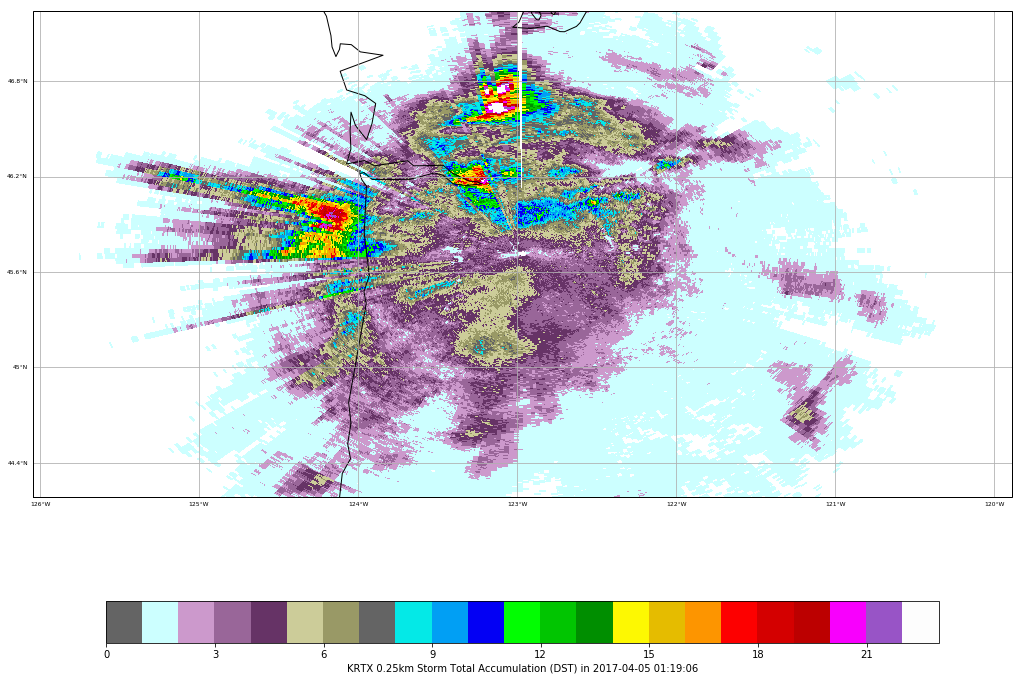

In [50]:
for rec in grids:
    code = rec["code"]
    bbox = rec["bbox"]
    lats = rec["lats"]
    lons = rec["lons"]
    data = rec["data"]
    
    # Create figure
    %matplotlib inline
    fig, ax = make_map(bbox=bbox)
    
    # Colortable filename, beginning value, increment
    ctable = nexrad[code]['ctable'][0]
    ctable = "NWSReflectivityExpanded"
    beg = nexrad[code]['ctable'][1]
    inc = nexrad[code]['ctable'][2]

    norm, cmap = ctables.registry.get_with_steps(ctable, beg, inc)
    cs = ax.pcolormesh(lons, lats, data, norm=norm, cmap=cmap)
    ax.set_aspect('equal', 'datalim')
    cbar = plt.colorbar(cs, shrink=0.85, orientation='horizontal')
    #cbar.ax.set_xticklabels(['0','10','20','30','40','50','60','70kft','topped'])
    cbar.set_label(nexid.upper()+" "+ str(nexrad[code]['res']/1000.) +"km " \
                   +nexrad[code]['name']+" ("+code+") " \
                   +nexrad[code]['unit']+" " \
                   +str(record.getDataTime()))
    political_boundaries = NaturalEarthFeature(category='cultural',
                                   name='admin_0_boundary_lines_land',
                                   scale='50m', facecolor='none')
    states = NaturalEarthFeature(category='cultural',
                                   name='admin_1_states_provinces_lakes',
                                   scale='50m', facecolor='none')
    ax.add_feature(political_boundaries, linestyle='-')
    ax.add_feature(states, linestyle='-')
    # Zoom
    ax.set_xlim(lon-1.5, lon+1.5)
    ax.set_ylim(lat-1.5, lat+1.5)

    plt.tight_layout()